In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#load data
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

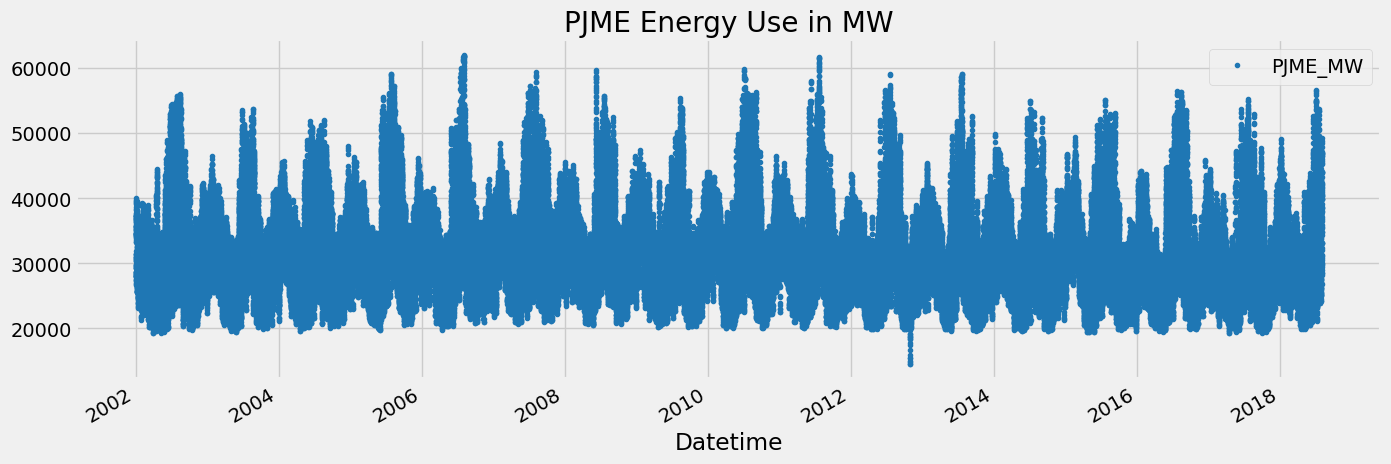

In [3]:
#view data/ graph
df.plot(style= '.',
       figsize= (15, 5),
       color= color_pal[0],
       title= 'PJME Energy Use in MW')
plt.show()

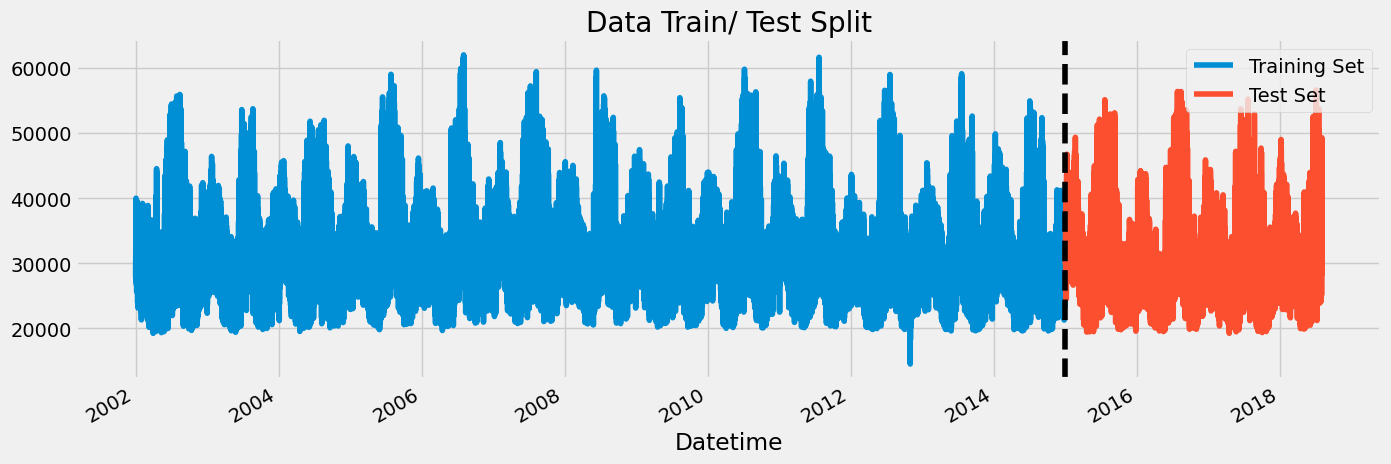

In [4]:
#train/ test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize= (15, 5))
train.plot(ax= ax, label= 'Training Set', title= 'Data Train/ Test Split')
test.plot(ax= ax, label= 'Test Set')
ax.axvline('01-01-2015', color= 'black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

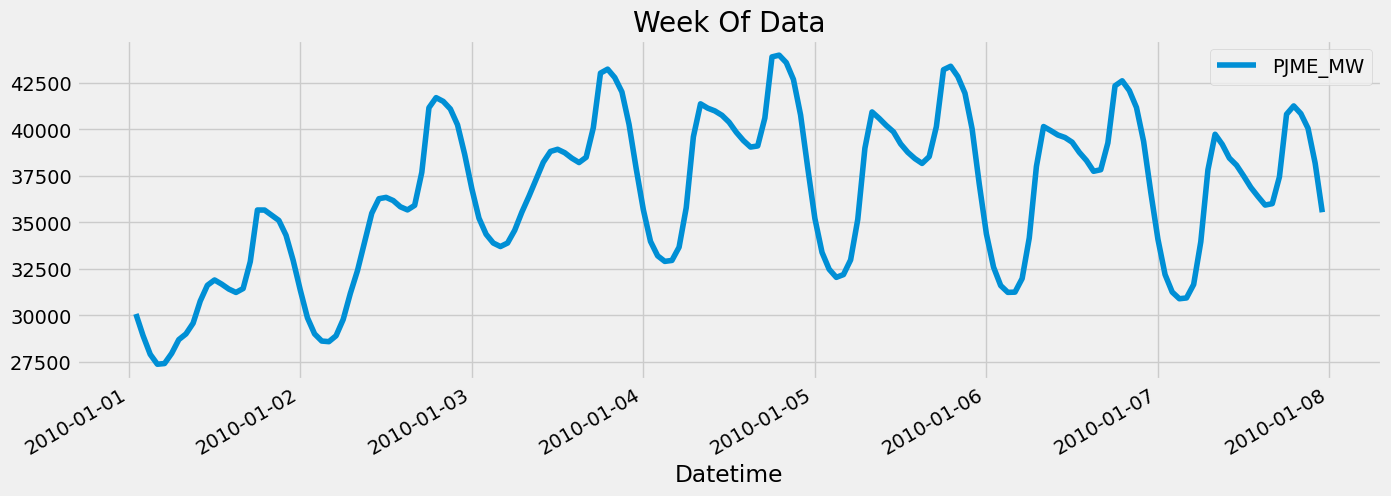

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
    .plot(figsize= (15, 5), title= 'Week Of Data')
plt.show()

In [6]:
#feature creation
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

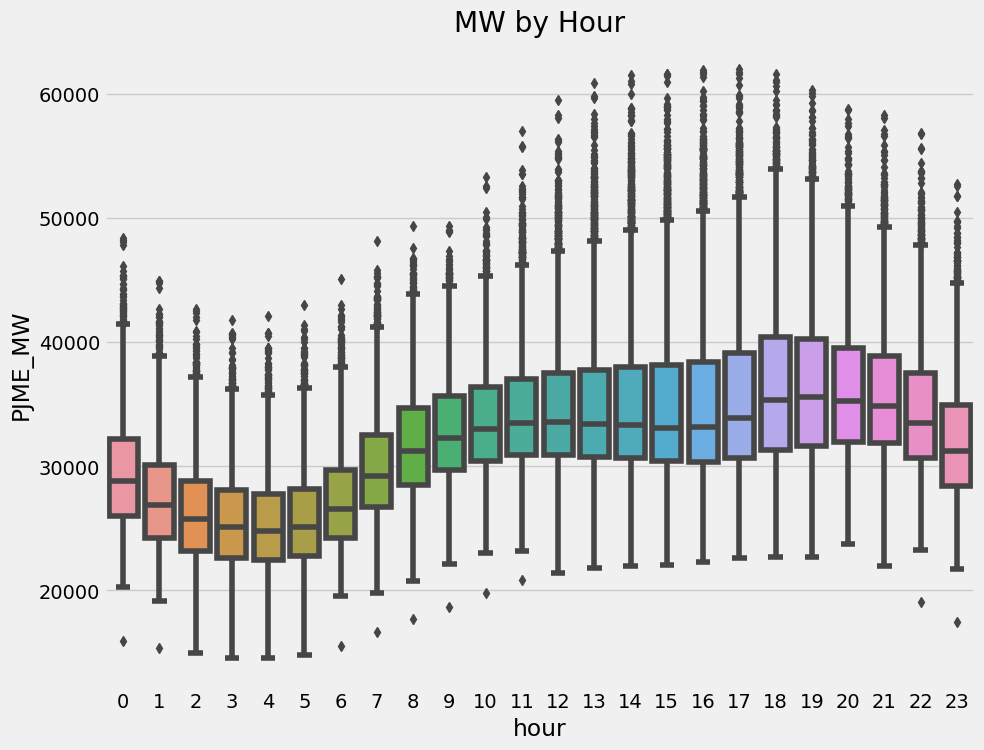

In [7]:
#visualize our feature/ target relationship
fig, ax = plt.subplots(figsize= (10,8))
sns.boxplot(data= df, x= 'hour', y= 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

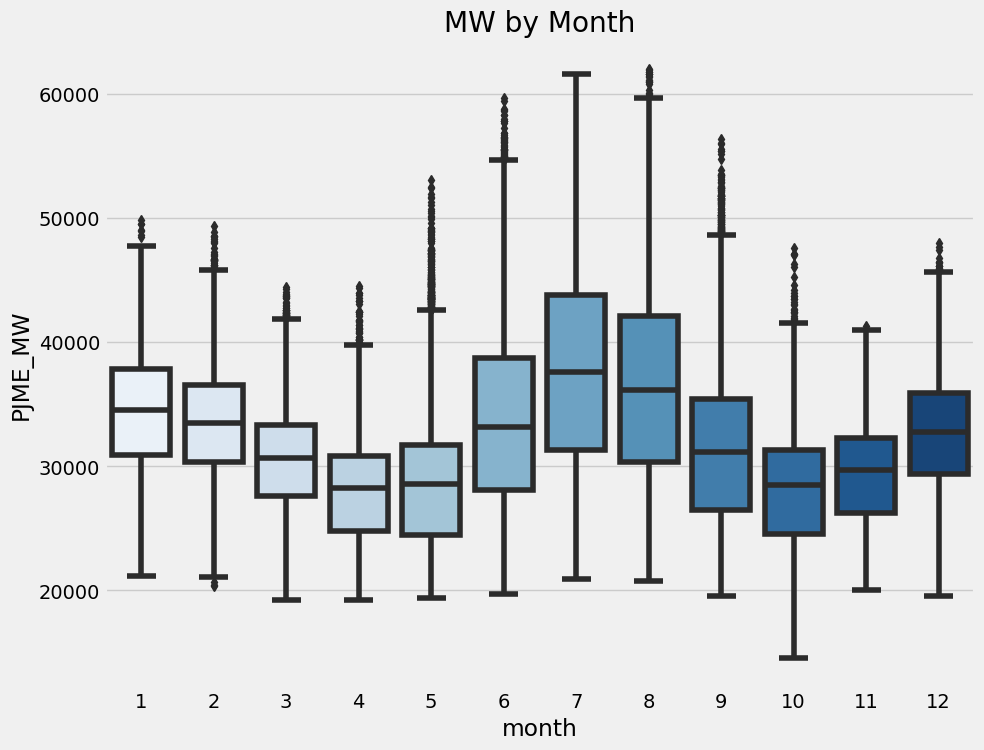

In [8]:
fig, ax= plt.subplots(figsize= (10,8))
sns.boxplot(data= df, x= 'month', y= 'PJME_MW', palette= 'Blues')
ax.set_title('MW by Month')
plt.show()

In [9]:
#create our model
train= create_features(train)
test= create_features(test)

FEATURES= ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET= 'PJME_MW'

X_train= train[FEATURES]
y_train= train[TARGET]

X_test= test[FEATURES]
y_test= test[TARGET]

In [10]:
reg= xgb.XGBRegressor(base_score= 0.5, booster= 'gbtree',
                     n_estimators= 1000,
                     early_stopping_rounds= 50,
                     objective= 'reg:linear',
                     max_depth= 3,
                     learning_rate= 0.01)

reg.fit(X_train, y_train,
       eval_set= [(X_train, y_train), (X_test, y_test)],
       verbose= 100)

[18:37:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

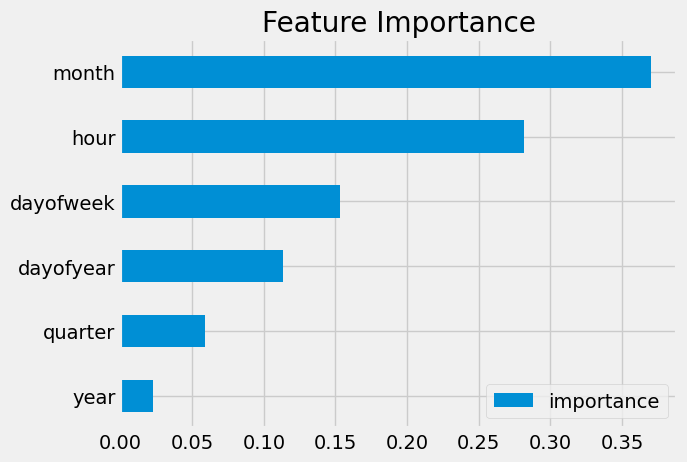

In [11]:
#feature importance
fi= pd.DataFrame(data= reg.feature_importances_,
                index= reg.feature_names_in_,
                columns= ['importance'])

fi.sort_values('importance').plot(kind= 'barh', title= 'Feature Importance')
plt.show()

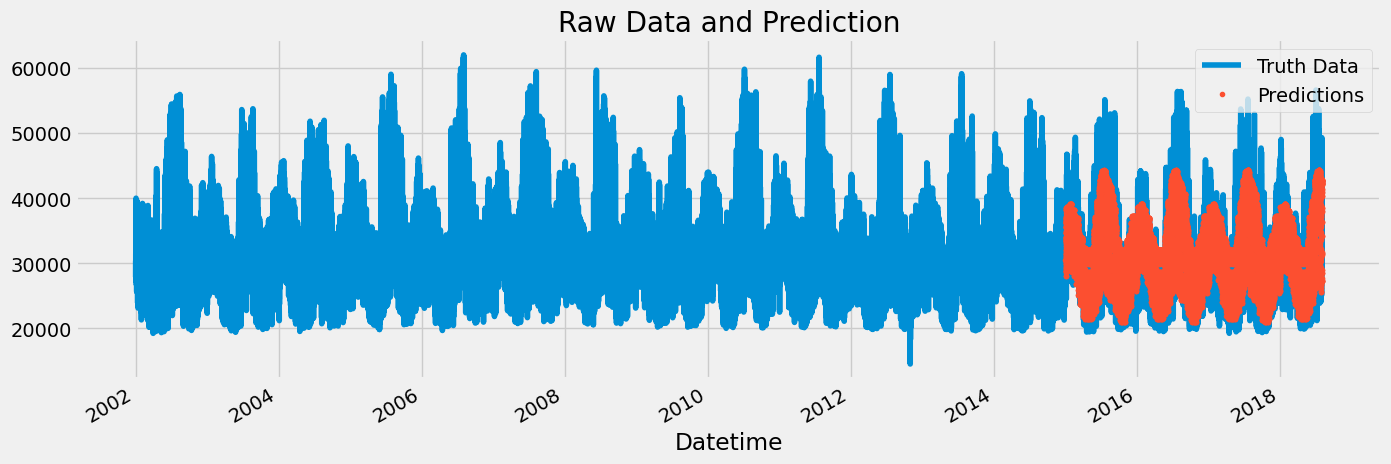

In [12]:
#forecast on test
test['prediction']= reg.predict(X_test)
df= df.merge(test[['prediction']], how= 'left', left_index= True, right_index= True)
ax= df[['PJME_MW']].plot(figsize= (15, 5))
df['prediction'].plot(ax= ax, style= '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

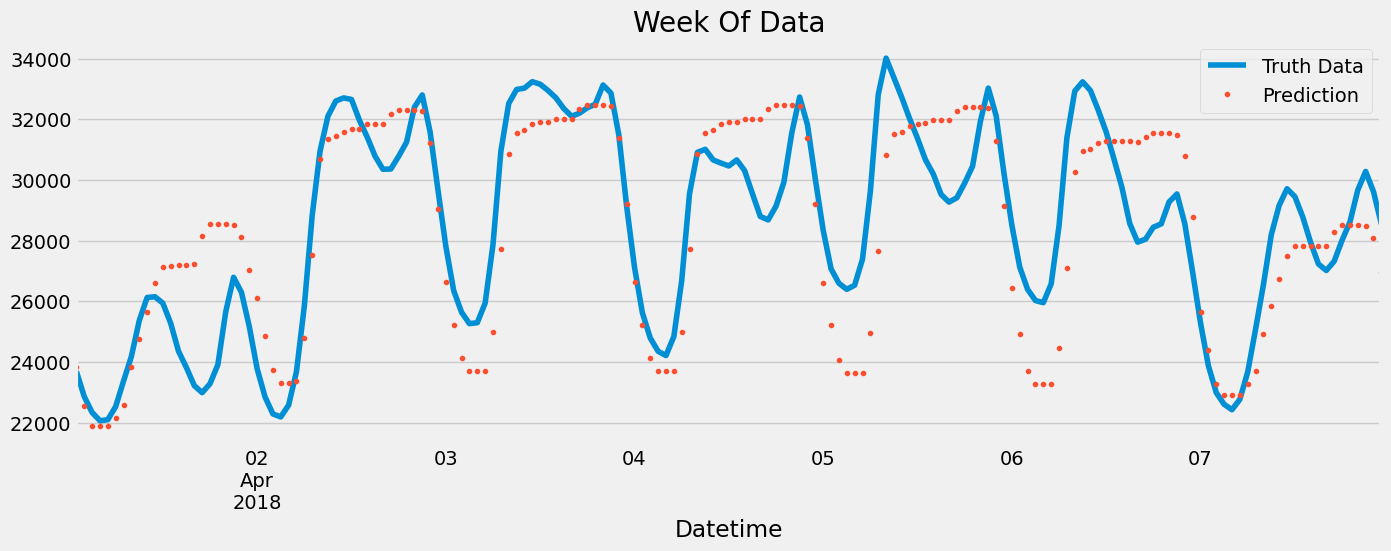

In [13]:
ax= df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] ['PJME_MW']\
    .plot(figsize= (15, 5), title= 'Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] ['prediction']\
    .plot(style= '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [14]:
#RMSE score
score= np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3721.75


In [15]:
#calculate error
#worst predicted days
test['error']= np.abs(test[TARGET]- test['prediction'])
test['date']= test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending= False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

In [16]:
#calculate error
#best predicted days
test['error']= np.abs(test[TARGET]- test['prediction'])
test['date']= test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending= True).head(10)

date
2017-10-24    349.390462
2015-10-28    397.410807
2016-10-27    528.968913
2015-05-06    529.528971
2017-10-15    535.292318
2018-05-16    585.349935
2016-10-08    625.825439
2015-10-03    653.130941
2016-09-16    656.402995
2015-11-06    674.912109
Name: error, dtype: float64